# Example code for loading dicom images and subject information for EMC Hackathon 2024

In [1]:
import sys
if sys.version_info[0] < 3:
    raise Exception("Must be using Python 3")

In [2]:
sys.version_info

sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0)

In [45]:
#install needed packages
#pip install matplotlib
#pip install pydicom
#pip install pandas
##pip install skimage
#pip install scikit-image
#pip install tensorflow
#pip install scikit-learn

  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-ja84uel7/tensorflow-gpu_f30003a6568b464ebf086f968b650b61/setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  Running

In [4]:
import matplotlib

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Load needed packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom
import numpy as np
import pandas as pd
import os
import skimage
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

2024-09-19 20:17:48.302499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 20:17:48.329365: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 20:17:48.337269: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 20:17:48.356009: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-19 20:17:49.995323: W tensorflow/compiler/tf2

## Define paths and input files

In [5]:
#Load file containing training samples
main_dir = r"/mnt/bigr0006/data/"
train_filename = "training_set_full_with_na.csv"
img_folder = "train"


df_train = pd.read_csv(os.path.join(main_dir, train_filename))

#first few rows of dataset
df_train.head()


,dataset,subject_id,visit,hip_side,dicom_image,hip_oa_grade,age_baseline,bmi_baseline,sex_assigned_birth,set
0,CHECK,CHECK-01001,T02,left,CHECK-01001-T02-LH.dcm,0,46,26.0,Male,train
1,CHECK,CHECK-01001,T02,right,CHECK-01001-T02-RH.dcm,0,46,26.0,Male,train
2,CHECK,CHECK-01001,T05,left,CHECK-01001-T05-LH.dcm,0,46,26.0,Male,train
3,CHECK,CHECK-01001,T05,right,CHECK-01001-T05-RH.dcm,0,46,26.0,Male,train
4,CHECK,CHECK-01001,T08,left,CHECK-01001-T08-LH.dcm,0,46,26.0,Male,train


## Visualize distribution of data

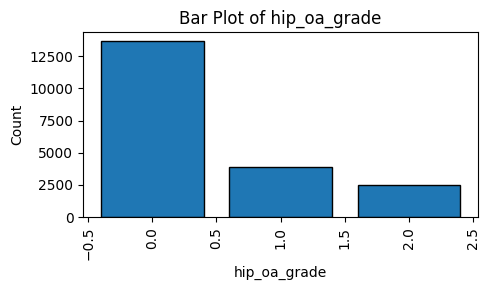

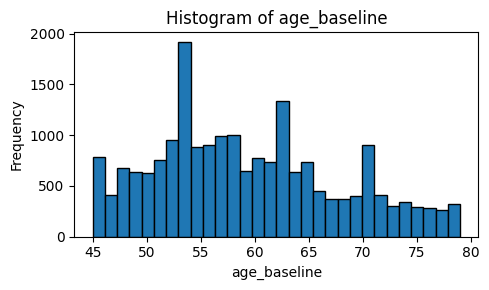

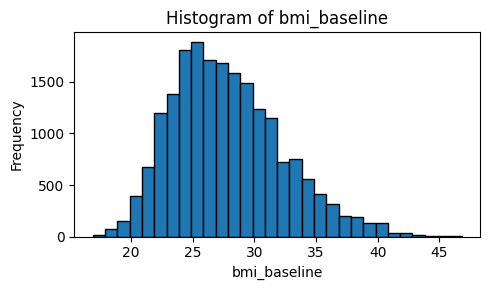

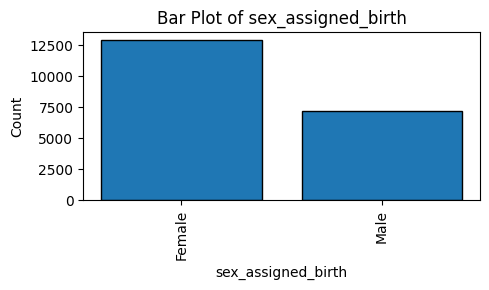

In [6]:
def visualize_dataframe(df):
    """
    This function takes a pandas DataFrame and plots a histogram for numerical columns
    and a bar plot for categorical columns using only matplotlib.
    """
    for column in df.columns:
        plt.figure(figsize=(5, 3))
        
        if pd.api.types.is_numeric_dtype(df[column]):
            plt.hist(df[column].dropna(), bins=30, edgecolor='k')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.title(f'Histogram of {column}')
        
        elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == object:
            counts = df[column].value_counts()
            plt.bar(counts.index, counts.values, edgecolor='k')
            plt.xlabel(column)
            plt.ylabel('Count')
            plt.title(f'Bar Plot of {column}')
            plt.xticks(rotation=90)  # Rotate x-axis labels if necessary
        
        plt.tight_layout()
        plt.show()

df_train['hip_oa_grade'] = df_train['hip_oa_grade'].astype('category')
visualize_dataframe(df_train[['hip_oa_grade', 'age_baseline', 'bmi_baseline', 'sex_assigned_birth']])

In [7]:
# reminder to balance training set on grade and sex, which are unbalanced

## Load and resample a train image to a target resolution

Image size: (2590, 1501)
Input pixel spacing: [0.143, 0.143]


Text(0.5, 1.0, 'Original Image')

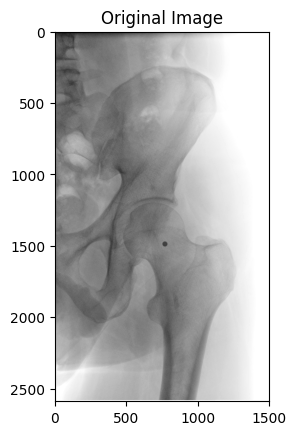

In [8]:
#Load and plot dicom image
image_file_dicom = os.path.join(main_dir, img_folder, df_train['dicom_image'][0])
img = pydicom.dcmread(image_file_dicom)
print(f"Image size: {img.pixel_array.shape}")

# extract pixel spacing (mm/pixel) from the DICOM headers
source_pixel_spacing = img.get('PixelSpacing') or img.get('ImagerPixelSpacing')
assert source_pixel_spacing is not None, 'no pixel spacing found'
assert source_pixel_spacing[0] == source_pixel_spacing[1], 'asymmetric pixel spacing is untested'
pixel_spacing = source_pixel_spacing
print('Input pixel spacing:', source_pixel_spacing)

plt.imshow(img.pixel_array, 'gray')
#plt.imshow(np.fliplr(img.pixel_array), 'gray')
plt.title('Original Image')

Scaling factor: 0.35749999999999993
Source image size: (2590, 1501)
Resized image size: (926, 537)


Text(0.5, 1.0, 'Resampled Image')

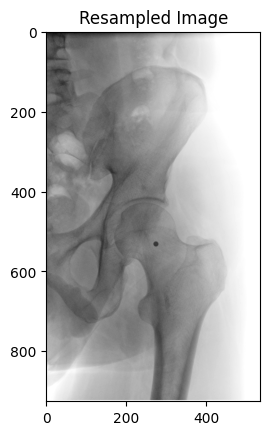

In [9]:
# resample to the required resolution
target_pixel_spacing = 0.4 #example

scale_factor = source_pixel_spacing[0] / target_pixel_spacing
print('Scaling factor:', scale_factor)

print('Source image size:', img.pixel_array.shape)
img_pixels = skimage.transform.rescale(img.pixel_array, scale_factor)
print('Resized image size:', img_pixels.shape)

pixel_spacing = [target_pixel_spacing, target_pixel_spacing]

plt.imshow(img_pixels, 'gray')
plt.title('Resampled Image')

Photometric interpretation MONOCHROME1: inverting intensities


Text(0.5, 1.0, 'Resampled & Processed Image')

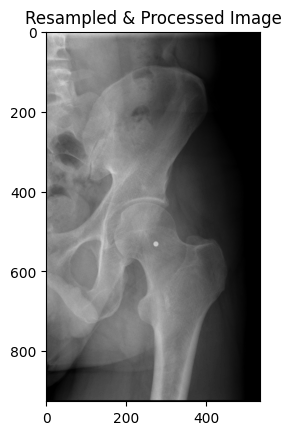

In [10]:
#additional checks on image intensities

# are the intensities stored as MONOCHROME2 (white=max, black=min) or
# as MONOCHROME1 (white=min, black=max)?
photometric_interpretation = img.get('PhotometricInterpretation')
if photometric_interpretation == 'MONOCHROME1':
    print('Photometric interpretation MONOCHROME1: inverting intensities')
    img_pixels = np.max(img_pixels) - img_pixels
else:
    assert photometric_interpretation == 'MONOCHROME2',\
        f'{photometric_interpretation} not supported'

# other checks
assert img.get('VOILUTFunction', 'LINEAR') == 'LINEAR', \
    'only supporting VOILUTFunction LINEAR'

plt.imshow(img_pixels, 'gray')
plt.title('Resampled & Processed Image')

In [11]:
# Processing function
def scale_and_check_dicom_image(img, target_pixel_spacing):
    source_pixel_spacing = img.get('PixelSpacing') or img.get('ImagerPixelSpacing')
    assert source_pixel_spacing is not None, 'no pixel spacing found'
    assert source_pixel_spacing[0] == source_pixel_spacing[1], 'asymmetric pixel spacing is untested'

    scale_factor = source_pixel_spacing[0] / target_pixel_spacing
    img_pixels = skimage.transform.rescale(img.pixel_array, scale_factor)
    pixel_spacing = [target_pixel_spacing, target_pixel_spacing]
    
    photometric_interpretation = img.get('PhotometricInterpretation')
    if photometric_interpretation == 'MONOCHROME1':
        print('Photometric interpretation MONOCHROME1: inverting intensities')
        img_pixels = np.max(img_pixels) - img_pixels
    else:
        assert photometric_interpretation == 'MONOCHROME2',\
            f'{photometric_interpretation} not supported'

    # other checks
    assert img.get('VOILUTFunction', 'LINEAR') == 'LINEAR', \
        'only supporting VOILUTFunction LINEAR'
    
    return img_pixels, pixel_spacing



## Load and visualize images of 10 randomly selected train samples 

Photometric interpretation MONOCHROME1: inverting intensities
Photometric interpretation MONOCHROME1: inverting intensities


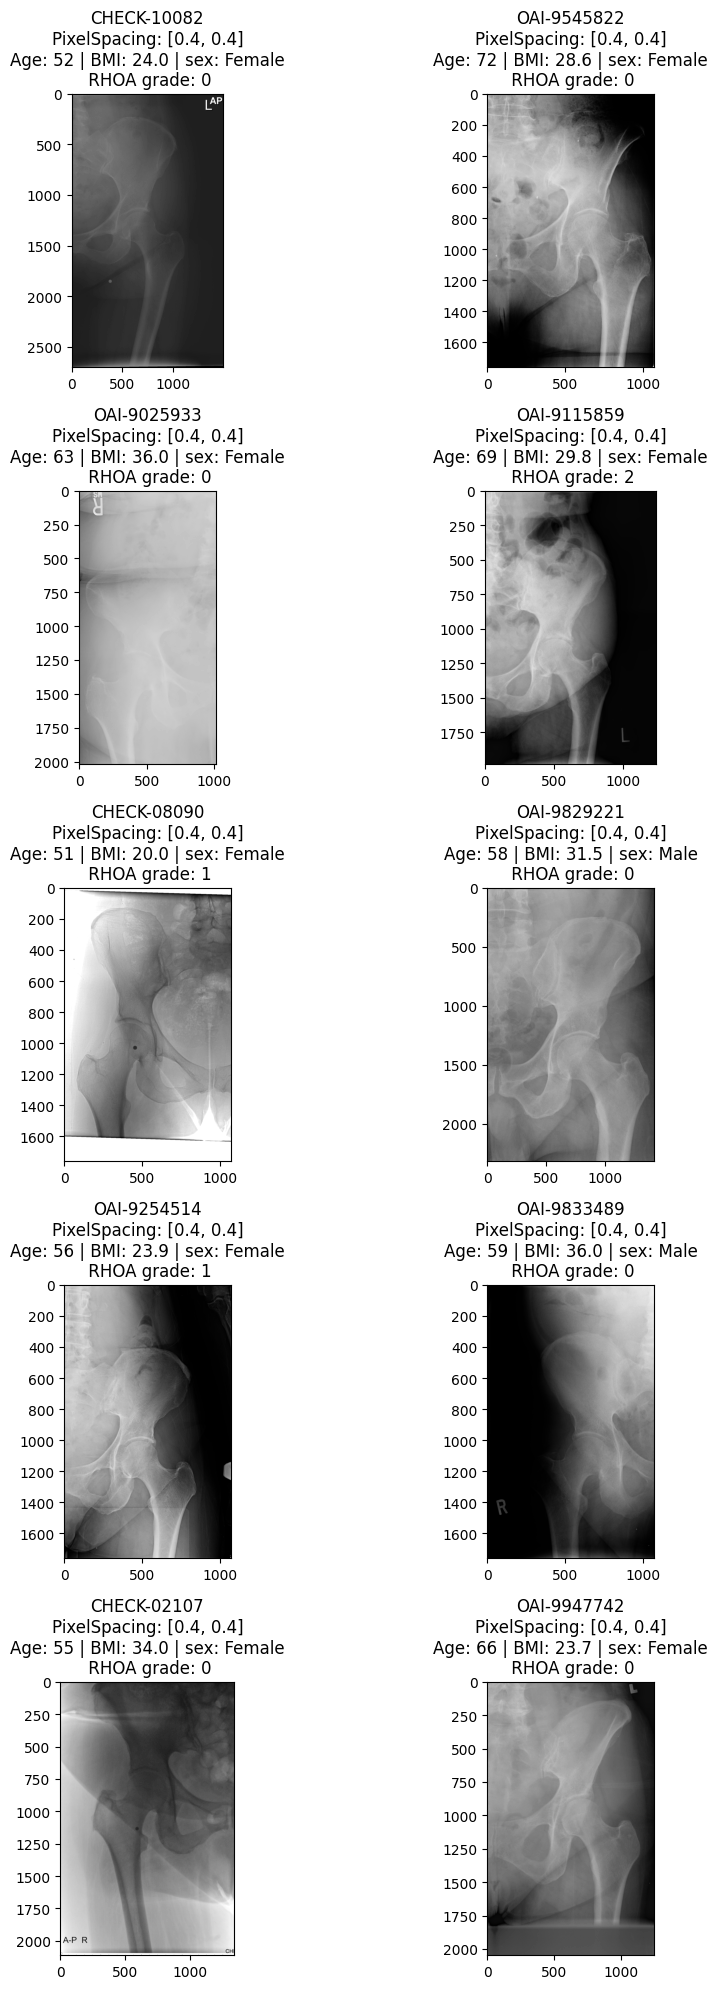

In [12]:
#select 10 samples randomly
df_train_subset10 = df_train.sample(n=10).reset_index()

#create plot for visualisation
fig, ax = plt.subplots(5,2, figsize=(10, 20))
axes = ax.ravel()

#loop over subset of train samples

for index, row in df_train_subset10.iterrows():
    img = pydicom.dcmread(os.path.join(main_dir, img_folder, row['dicom_image']))
    img_pixels, pixel_spacing = scale_and_check_dicom_image(img, 0.4)
    axes[index].imshow(img.pixel_array, 'gray')
    
    axes[index].set_title(f"{row['subject_id']}\nPixelSpacing: {pixel_spacing}\nAge: {row['age_baseline']} | BMI: {row['bmi_baseline']} | sex: {row['sex_assigned_birth']}\n RHOA grade: {row['hip_oa_grade']}")
fig.tight_layout()
fig.show()

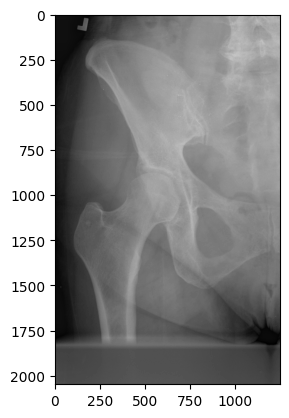

In [13]:
# flipping hip for consistency
#df_train[df_train["hip_side"]=="left"]

#code to flip horizontally
plt.imshow(np.fliplr(img.pixel_array), 'gray')

In [14]:
#dividing available data into training and test set


In [15]:
df_train.head()

,dataset,subject_id,visit,hip_side,dicom_image,hip_oa_grade,age_baseline,bmi_baseline,sex_assigned_birth,set
0,CHECK,CHECK-01001,T02,left,CHECK-01001-T02-LH.dcm,0,46,26.0,Male,train
1,CHECK,CHECK-01001,T02,right,CHECK-01001-T02-RH.dcm,0,46,26.0,Male,train
2,CHECK,CHECK-01001,T05,left,CHECK-01001-T05-LH.dcm,0,46,26.0,Male,train
3,CHECK,CHECK-01001,T05,right,CHECK-01001-T05-RH.dcm,0,46,26.0,Male,train
4,CHECK,CHECK-01001,T08,left,CHECK-01001-T08-LH.dcm,0,46,26.0,Male,train


In [32]:
y_train = df_train["hip_oa_grade"]
X_train = df_train[["dicom_image", "visit","age_baseline","bmi_baseline","sex_assigned_birth"]]

In [33]:
stratify_labels = [f"{sex}_{grade}" for sex, grade in zip(X_train["sex_assigned_birth"], y_train)]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, 
                                                    stratify=stratify_labels, random_state=42)

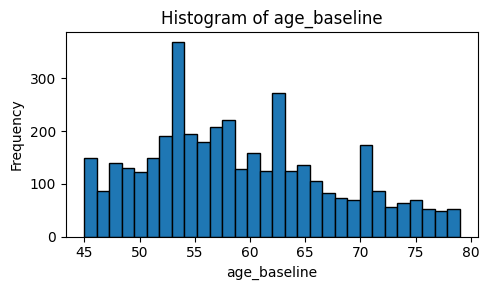

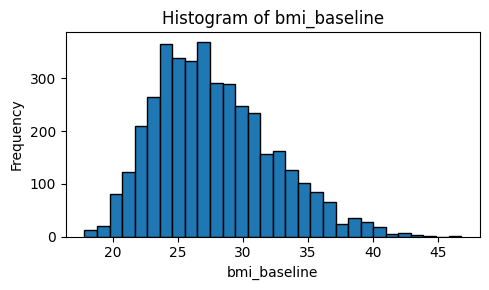

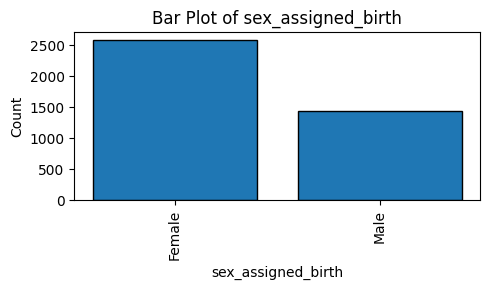

In [19]:
def visualize_dataframe(df):
    """
    This function takes a pandas DataFrame and plots a histogram for numerical columns
    and a bar plot for categorical columns using only matplotlib.
    """
    for column in df.columns:
        plt.figure(figsize=(5, 3))
        
        if pd.api.types.is_numeric_dtype(df[column]):
            plt.hist(df[column].dropna(), bins=30, edgecolor='k')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.title(f'Histogram of {column}')
        
        elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == object:
            counts = df[column].value_counts()
            plt.bar(counts.index, counts.values, edgecolor='k')
            plt.xlabel(column)
            plt.ylabel('Count')
            plt.title(f'Bar Plot of {column}')
            plt.xticks(rotation=90)  # Rotate x-axis labels if necessary
        
        plt.tight_layout()
        plt.show()


visualize_dataframe(X_test[['age_baseline', 'bmi_baseline', 'sex_assigned_birth']])

In [38]:
y_train_cat = tf.keras.utils.to_categorical(y_train, 4)
y_test_cat = tf.keras.utils.to_categorical(y_test, 4)

In [39]:
model = models.Sequential()

In [41]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([10939,  3122,  2015]))

In [42]:
print(f"Shape of input images: {X_train.shape}")
print(f"Shape of output labels (one-hot encoded): {y_train.shape}")

Shape of input images: (16076, 5)
Shape of output labels (one-hot encoded): (16076,)


In [46]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [48]:
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU!")
else:
    print("TensorFlow is using the CPU.")

TensorFlow is using the CPU.


In [43]:
# Add convolutional layers followed by pooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

I0000 00:00:1726770263.505248   55365 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-19 20:24:23.948456: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
